In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

**Split**

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# read dataset
df = pd.read_csv("training_data_75.csv")

# Target for classification is the threshold value
y = df["min_threshold"].astype(int).values

# Group (so all rows of same circuit stay together)
groups = df["file"].astype(str).values

# Drop columns we dont want as features
drop_cols = [
    "min_threshold",   # target
    "file",
    "family",
    "forward_runtime", # not for classification, only regression
    "max_fidelity_achieved",
    "forward_shots",
    "forward_peak_rss_mb",
    "n_thresholds_tested",
]
drop_cols = [c for c in drop_cols if c in df.columns]

# X is equal to the whole dataset - dropped columns
X = df.drop(columns=drop_cols).copy()

# encode categorical columns (backend/precision/etc.)
X = pd.get_dummies(X, columns=[c for c in X.columns if X[c].dtype == "object" or X[c].dtype == "str"])

# ---------------------------
# Stratified split BY FILE, stratified by n_qubits bucket
# ---------------------------

# 1) Build a file-level table for stratification
file_info = df.groupby("file", as_index=False).agg(
    n_qubits=("n_qubits", "first")
)

# Bucketize n_qubits so stratification is stable (avoids classes with only 1 file)
file_info["qubit_bucket"] = pd.cut(
    file_info["n_qubits"],
    bins=[-1, 20, 60, 10**9],
    labels=["small", "medium", "large"]
)

# 2) Optional: force rare-threshold files into TRAIN (helps avoid "unseen class 256")
forced_train_files = set(df.loc[df["min_threshold"] == 256, "file"].unique())

# Split only on remaining files (pool)
pool = file_info[~file_info["file"].isin(forced_train_files)].reset_index(drop=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_f_idx, test_f_idx = next(sss.split(pool["file"], pool["qubit_bucket"]))

train_files = set(pool.loc[train_f_idx, "file"])
test_files  = set(pool.loc[test_f_idx, "file"])

# Add forced files to train
train_files |= forced_train_files

# Convert file sets -> row indices
train_idx = df.index[df["file"].isin(train_files)].to_numpy()
test_idx  = df.index[df["file"].isin(test_files)].to_numpy()

# Final arrays
x_train = X.iloc[train_idx].values.astype(np.float32)
x_test  = X.iloc[test_idx].values.astype(np.float32)
y_train = y[train_idx]
y_test  = y[test_idx]

# sanity checks
print("Shapes:", x_train.shape, x_test.shape)
print("Train classes:", sorted(np.unique(y_train)))
print("Test classes:", sorted(np.unique(y_test)))

overlap = train_files.intersection(test_files)
print("Unique files train:", len(train_files), "test:", len(test_files), "overlap:", len(overlap))


Shapes: (102, 66) (35, 66)
Train classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
Test classes: [np.int64(1), np.int64(2), np.int64(4)]
Unique files train: 27 test: 9 overlap: 0


**Metricas**

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score

def cls_metrics(y_true, y_pred, name="model"):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    under = np.mean(y_pred < y_true)   # super importante en tu reto
    over  = np.mean(y_pred > y_true)

    #print(f"{name}")
    #print("  Accuracy:", round(acc, 4))
    #print("  Under-rate (pred < true):", round(float(under), 4))
    #print("  Over-rate  (pred > true):", round(float(over), 4))
    
    return acc


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=42)),
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    x_train,
    y_train,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
)

print("CV accuracy:", scores.mean())
print("CV std:", scores.std())

CV accuracy: 0.9215686274509803
CV std: 0.06932419423397526


/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


0.9142857142857143


## K-Fold Cross-Validation

The single train/test split above has issues:
- Test set only contains 3 of 6 classes
- Only 35 test samples (too small for reliable estimates)
- Leads to suspicious "exactly 80%" accuracy ceiling

K-Fold CV fixes this by:
- Evaluating on ALL data (each sample tested exactly once)
- Using StratifiedGroupKFold to keep files together (no leakage) while balancing classes
- Providing mean ± std accuracy across folds for reliability

In [83]:
"""
Stratified Group K-Fold Cross-Validation
-----------------------------------------
- Groups by file (no data leakage - same circuit stays together)
- Stratified by class to ensure all classes appear in each fold
- Reports mean ± std accuracy across folds
"""

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_with_kfold(clf_class, clf_params, X, y, groups, n_splits=5, name="Model"):
    """
    Evaluate a classifier using Stratified Group K-Fold CV.
    
    Args:
        clf_class: The classifier class (e.g., HistGradientBoostingClassifier)
        clf_params: Dict of parameters to pass to the classifier
        X: Feature matrix
        y: Target labels
        groups: Group labels (file names) to keep together
        n_splits: Number of CV folds
        name: Display name for the model
    
    Returns:
        Dict with mean accuracy, std, and per-fold results
    """
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    fold_class_counts = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Track which classes appear in this fold's test set
        test_classes = np.unique(y_test)
        fold_class_counts.append(len(test_classes))
        
        # Train and predict
        clf = clf_class(**clf_params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate accuracy for this fold
        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)
        
        # Collect for overall confusion matrix
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        print(f"  Fold {fold_idx + 1}: Acc={acc:.4f}, Test classes={sorted(test_classes)}, n_test={len(y_test)}")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    
    print(f"\n{name} - {n_splits}-Fold CV Results:")
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  Per-fold accuracies: {[round(a, 4) for a in fold_accuracies]}")
    print(f"  Avg classes per fold: {np.mean(fold_class_counts):.1f}")
    
    # Overall confusion matrix
    all_classes = sorted(np.unique(y))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=all_classes)
    
    print(f"\nConfusion Matrix (rows=true, cols=pred):")
    print(f"Classes: {all_classes}")
    print(cm)
    
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred, labels=all_classes, zero_division=0))
    
    return {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "fold_accuracies": fold_accuracies,
        "confusion_matrix": cm,
        "classes": all_classes
    }

In [84]:
# Prepare data for k-fold (use full dataset, not the train/test split)
X_full = X.values.astype(np.float32)
y_full = y
groups_full = groups

print(f"Full dataset: {len(y_full)} samples, {len(np.unique(groups_full))} files, {len(np.unique(y_full))} classes")
print(f"Class distribution: {dict(zip(*np.unique(y_full, return_counts=True)))}")
print("-" * 60)

Full dataset: 137 samples, 36 files, 6 classes
Class distribution: {np.int64(1): np.int64(54), np.int64(2): np.int64(46), np.int64(4): np.int64(6), np.int64(8): np.int64(17), np.int64(16): np.int64(12), np.int64(64): np.int64(2)}
------------------------------------------------------------


In [85]:
# Evaluate HistGradientBoostingClassifier with K-Fold
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "max_iter": 500,
    "random_state": 42
}

results_hgb = evaluate_with_kfold(
    HistGradientBoostingClassifier, 
    hgb_params, 
    X_full, y_full, groups_full, 
    n_splits=5, 
    name="HistGradientBoosting"
)

/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 1: Acc=0.7143, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 2: Acc=0.7407, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 3: Acc=0.4444, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 4: Acc=0.6429, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 5: Acc=0.6667, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16), np.int64(64)], n_test=27

HistGradientBoosting - 5-Fold CV Results:
  Mean Accuracy: 0.6418 ± 0.1045
  Per-fold accuracies: [0.7143, 0.7407, 0.4444, 0.6429, 0.6667]
  Avg classes per fold: 4.2

Confusion Matrix (rows=true, cols=pred):
Classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[48  6  0  0  0  0]
 [14 32  0  0  0  0]
 [ 5  0  0  0  1  0]
 [ 5  0  0  8  4  0]
 [ 4  0  0  4  0  4]
 [ 0  0  0  0  2  0]]

Classification Report:
              precision    recall  f1

In [86]:
# Evaluate RandomForestClassifier with K-Fold
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 300,
    "max_depth": None,
    "min_samples_leaf": 2,
    "random_state": 42,
    "n_jobs": -1,
    "class_weight": "balanced"
}

results_rf = evaluate_with_kfold(
    RandomForestClassifier, 
    rf_params, 
    X_full, y_full, groups_full, 
    n_splits=5, 
    name="RandomForest"
)

/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 1: Acc=0.8571, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 2: Acc=0.7407, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 3: Acc=0.4444, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 4: Acc=0.5000, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 5: Acc=0.5926, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16), np.int64(64)], n_test=27

RandomForest - 5-Fold CV Results:
  Mean Accuracy: 0.6270 ± 0.1527
  Per-fold accuracies: [0.8571, 0.7407, 0.4444, 0.5, 0.5926]
  Avg classes per fold: 4.2

Confusion Matrix (rows=true, cols=pred):
Classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[42 12  0  0  0  0]
 [14 32  0  0  0  0]
 [ 3  3  0  0  0  0]
 [ 5  0  0  8  4  0]
 [ 4  0  0  4  4  0]
 [ 0  0  0  0  2  0]]

Classification Report:
              precision    recall  f1-score   su

In [87]:
# Evaluate CatBoostClassifier with K-Fold
from catboost import CatBoostClassifier

cb_params = {
    "iterations": 300,
    "depth": 6,
    "learning_rate": 0.05,
    "loss_function": "MultiClass",
    "random_seed": 42,
    "verbose": False
}

results_cb = evaluate_with_kfold(
    CatBoostClassifier, 
    cb_params, 
    X_full, y_full, groups_full, 
    n_splits=5, 
    name="CatBoost"
)

/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 1: Acc=0.7143, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 2: Acc=0.7407, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 3: Acc=0.5926, Test classes=[np.int64(1), np.int64(2), np.int64(4), np.int64(8)], n_test=27
  Fold 4: Acc=0.6429, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16)], n_test=28
  Fold 5: Acc=0.5926, Test classes=[np.int64(1), np.int64(2), np.int64(8), np.int64(16), np.int64(64)], n_test=27

CatBoost - 5-Fold CV Results:
  Mean Accuracy: 0.6566 ± 0.0613
  Per-fold accuracies: [0.7143, 0.7407, 0.5926, 0.6429, 0.5926]
  Avg classes per fold: 4.2

Confusion Matrix (rows=true, cols=pred):
Classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[50  4  0  0  0  0]
 [14 32  0  0  0  0]
 [ 6  0  0  0  0  0]
 [ 5  4  0  8  0  0]
 [ 4  0  0  4  0  4]
 [ 0  0  0  0  2  0]]

Classification Report:
              precision    recall  f1-score   sup

In [88]:
# Summary comparison of all models
print("=" * 60)
print("SUMMARY: K-Fold Cross-Validation Results")
print("=" * 60)

summary = {
    "HistGradientBoosting": results_hgb,
    "RandomForest": results_rf,
    "CatBoost": results_cb,
}

for name, res in sorted(summary.items(), key=lambda x: -x[1]["mean_acc"]):
    print(f"{name:25s}: {res['mean_acc']:.4f} ± {res['std_acc']:.4f}")

print("\nNote: These results are more reliable than a single train/test split")
print("because every sample is evaluated exactly once across all folds.")

SUMMARY: K-Fold Cross-Validation Results
CatBoost                 : 0.6566 ± 0.0613
HistGradientBoosting     : 0.6418 ± 0.1045
RandomForest             : 0.6270 ± 0.1527

Note: These results are more reliable than a single train/test split
because every sample is evaluated exactly once across all folds.


## Improved Approach: Ordinal Regression

Since thresholds are powers of 2 (1, 2, 4, 8, 16, 64), this is an **ordinal classification** problem. 
Predicting 2 when true is 4 is "better" than predicting 1.

Strategy:
1. Transform target to `log2(threshold)` → [0, 1, 2, 3, 4, 6]
2. Train a regressor
3. Round predictions to nearest valid class
4. Use SMOTE to handle 27x class imbalance

In [89]:
# Ordinal regression utilities
import numpy as np

# Valid log2 thresholds in the dataset
VALID_LOG2_THRESHOLDS = np.array([0, 1, 2, 3, 4, 6])  # log2 of [1, 2, 4, 8, 16, 64]

def threshold_to_log2(y):
    """Convert threshold values to log2 scale."""
    return np.log2(y).astype(int)

def log2_to_threshold(y_log2):
    """Convert log2 values back to threshold values."""
    return (2 ** y_log2).astype(int)

def round_to_valid_threshold(y_pred_continuous):
    """Round continuous predictions to nearest valid log2 threshold."""
    y_pred_continuous = np.asarray(y_pred_continuous)
    # Find nearest valid threshold for each prediction
    distances = np.abs(y_pred_continuous[:, None] - VALID_LOG2_THRESHOLDS[None, :])
    nearest_idx = np.argmin(distances, axis=1)
    return VALID_LOG2_THRESHOLDS[nearest_idx]

def ordinal_accuracy(y_true_log2, y_pred_log2):
    """Accuracy after rounding to valid thresholds."""
    y_pred_rounded = round_to_valid_threshold(y_pred_log2)
    return np.mean(y_true_log2 == y_pred_rounded)

def mean_ordinal_distance(y_true_log2, y_pred_log2):
    """Mean distance in log2 steps (lower is better)."""
    y_pred_rounded = round_to_valid_threshold(y_pred_log2)
    return np.mean(np.abs(y_true_log2 - y_pred_rounded))

# Transform target
y_log2 = threshold_to_log2(y_full)
print(f"Original classes: {sorted(np.unique(y_full))}")
print(f"Log2 classes: {sorted(np.unique(y_log2))}")
print(f"Class distribution (log2): {dict(zip(*np.unique(y_log2, return_counts=True)))}")

Original classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
Log2 classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6)]
Class distribution (log2): {np.int64(0): np.int64(54), np.int64(1): np.int64(46), np.int64(2): np.int64(6), np.int64(3): np.int64(17), np.int64(4): np.int64(12), np.int64(6): np.int64(2)}


In [90]:
from sklearn.model_selection import StratifiedGroupKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error

def evaluate_ordinal_kfold(reg_class, reg_params, X, y_log2, groups, n_splits=5, use_smote=True, name="Model"):
    """
    Evaluate ordinal regression with K-Fold CV.
    
    Uses regression on log2(threshold), then rounds to valid classes.
    Optionally applies SMOTE to handle class imbalance.
    """
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_distances = []
    all_y_true = []
    all_y_pred = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(sgkf.split(X, y_log2, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_log2[train_idx], y_log2[test_idx]
        
        # Apply SMOTE to training data only
        if use_smote:
            try:
                # Use k_neighbors based on smallest class size
                min_class_size = min(np.bincount(y_train)[np.bincount(y_train) > 0])
                k = min(5, min_class_size - 1) if min_class_size > 1 else 1
                smote = SMOTE(random_state=42, k_neighbors=k)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
            except ValueError:
                # Fall back to no SMOTE if classes too small
                X_train_res, y_train_res = X_train, y_train
        else:
            X_train_res, y_train_res = X_train, y_train
        
        # Train regressor
        reg = reg_class(**reg_params)
        reg.fit(X_train_res, y_train_res)
        y_pred_continuous = reg.predict(X_test)
        
        # Round to valid thresholds
        y_pred_rounded = round_to_valid_threshold(y_pred_continuous)
        
        # Calculate metrics
        acc = np.mean(y_test == y_pred_rounded)
        dist = np.mean(np.abs(y_test - y_pred_rounded))
        
        fold_accuracies.append(acc)
        fold_distances.append(dist)
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred_rounded)
        
        print(f"  Fold {fold_idx + 1}: Acc={acc:.4f}, Mean dist={dist:.2f} log2 steps")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    mean_dist = np.mean(fold_distances)
    
    print(f"\n{name} - Ordinal Regression Results:")
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  Mean Distance: {mean_dist:.2f} log2 steps (lower is better)")
    print(f"  SMOTE: {'enabled' if use_smote else 'disabled'}")
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    all_classes = sorted(np.unique(y_log2))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=all_classes)
    print(f"\nConfusion Matrix (log2 scale):")
    print(f"Classes: {all_classes} → thresholds {[2**c for c in all_classes]}")
    print(cm)
    
    return {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "mean_dist": mean_dist,
        "fold_accuracies": fold_accuracies
    }

In [60]:
# Test ordinal regression with HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_reg_params = {
    "learning_rate": 0.05,
    "max_depth": 6,
    "max_iter": 500,
    "random_state": 42
}

results_hgb_ordinal = evaluate_ordinal_kfold(
    HistGradientBoostingRegressor,
    hgb_reg_params,
    X_full, y_log2, groups_full,
    n_splits=5,
    use_smote=True,
    name="HistGradientBoosting (Ordinal)"
)

/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 1: Acc=0.6429, Mean dist=0.50 log2 steps
  Fold 2: Acc=0.5926, Mean dist=0.81 log2 steps
  Fold 3: Acc=0.4444, Mean dist=0.67 log2 steps
  Fold 4: Acc=0.5000, Mean dist=1.21 log2 steps
  Fold 5: Acc=0.5926, Mean dist=0.63 log2 steps

HistGradientBoosting (Ordinal) - Ordinal Regression Results:
  Mean Accuracy: 0.5545 ± 0.0718
  Mean Distance: 0.77 log2 steps (lower is better)
  SMOTE: enabled

Confusion Matrix (log2 scale):
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6)] → thresholds [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[48  6  0  0  0  0]
 [14 28  0  0  4  0]
 [ 6  0  0  0  0  0]
 [ 5  0 12  0  0  0]
 [ 4  0  0  4  0  4]
 [ 0  0  0  2  0  0]]


## Hyperparameter Tuning with Optuna

Systematic search for optimal hyperparameters using cross-validation as the objective.

In [61]:
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
from imblearn.over_sampling import SMOTE
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """Optuna objective for ordinal regression with SMOTE."""
    
    # Choose model type
    model_type = trial.suggest_categorical("model_type", ["hgb", "rf", "catboost"])
    
    if model_type == "hgb":
        params = {
            "learning_rate": trial.suggest_float("hgb_lr", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("hgb_depth", 3, 12),
            "max_iter": trial.suggest_int("hgb_iter", 100, 1000),
            "min_samples_leaf": trial.suggest_int("hgb_min_samples", 1, 20),
            "l2_regularization": trial.suggest_float("hgb_l2", 0.0, 1.0),
            "random_state": 42
        }
        model_class = HistGradientBoostingRegressor
        
    elif model_type == "rf":
        params = {
            "n_estimators": trial.suggest_int("rf_n_est", 100, 500),
            "max_depth": trial.suggest_int("rf_depth", 3, 20),
            "min_samples_leaf": trial.suggest_int("rf_min_samples", 1, 10),
            "min_samples_split": trial.suggest_int("rf_min_split", 2, 10),
            "random_state": 42,
            "n_jobs": -1
        }
        model_class = RandomForestRegressor
        
    else:  # catboost
        from catboost import CatBoostRegressor
        params = {
            "iterations": trial.suggest_int("cb_iter", 100, 800),
            "depth": trial.suggest_int("cb_depth", 3, 10),
            "learning_rate": trial.suggest_float("cb_lr", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("cb_l2", 1.0, 10.0),
            "random_seed": 42,
            "verbose": False
        }
        model_class = CatBoostRegressor
    
    # K-fold CV with SMOTE
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_idx, test_idx in sgkf.split(X_full, y_log2, groups_full):
        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y_log2[train_idx], y_log2[test_idx]
        
        # SMOTE
        try:
            min_class_size = min(np.bincount(y_train)[np.bincount(y_train) > 0])
            k = min(5, min_class_size - 1) if min_class_size > 1 else 1
            smote = SMOTE(random_state=42, k_neighbors=k)
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        except:
            X_train_res, y_train_res = X_train, y_train
        
        # Train and predict
        model = model_class(**params)
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_pred_rounded = round_to_valid_threshold(y_pred)
        
        acc = np.mean(y_test == y_pred_rounded)
        fold_scores.append(acc)
    
    return np.mean(fold_scores)

# Run optimization
study = optuna.create_study(direction="maximize", study_name="ordinal_threshold")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nBest trial:")
print(f"  Accuracy: {study.best_value:.4f}")
print(f"  Params: {study.best_params}")

/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                         | 0/100 [00:00<?, ?it/s]/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 0. Best value: 0.567725:   1%|▎                           | 1/100 [00:07<11:39,  7.06s/it]/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 0. Best value: 0.567725:   2%|▌          


Best trial:
  Accuracy: 0.6556
  Params: {'model_type': 'catboost', 'cb_iter': 287, 'cb_depth': 3, 'cb_lr': 0.04422552777187997, 'cb_l2': 4.675850509770569}


In [62]:
# Evaluate the best model found by Optuna
best_params = study.best_params
model_type = best_params.pop("model_type")

print(f"Best model: {model_type}")
print(f"Best params: {best_params}")

# Build params dict for the winning model
if model_type == "hgb":
    final_params = {
        "learning_rate": best_params["hgb_lr"],
        "max_depth": best_params["hgb_depth"],
        "max_iter": best_params["hgb_iter"],
        "min_samples_leaf": best_params["hgb_min_samples"],
        "l2_regularization": best_params["hgb_l2"],
        "random_state": 42
    }
    final_model_class = HistGradientBoostingRegressor
    
elif model_type == "rf":
    final_params = {
        "n_estimators": best_params["rf_n_est"],
        "max_depth": best_params["rf_depth"],
        "min_samples_leaf": best_params["rf_min_samples"],
        "min_samples_split": best_params["rf_min_split"],
        "random_state": 42,
        "n_jobs": -1
    }
    final_model_class = RandomForestRegressor
    
else:  # catboost
    from catboost import CatBoostRegressor
    final_params = {
        "iterations": best_params["cb_iter"],
        "depth": best_params["cb_depth"],
        "learning_rate": best_params["cb_lr"],
        "l2_leaf_reg": best_params["cb_l2"],
        "random_seed": 42,
        "verbose": False
    }
    final_model_class = CatBoostRegressor

# Full evaluation with the best model
print("\n" + "="*60)
results_best = evaluate_ordinal_kfold(
    final_model_class,
    final_params,
    X_full, y_log2, groups_full,
    n_splits=5,
    use_smote=True,
    name=f"Best Model ({model_type})"
)

Best model: catboost
Best params: {'cb_iter': 287, 'cb_depth': 3, 'cb_lr': 0.04422552777187997, 'cb_l2': 4.675850509770569}

  Fold 1: Acc=0.8571, Mean dist=0.14 log2 steps
  Fold 2: Acc=0.7407, Mean dist=0.52 log2 steps


/Users/hari/CODE/python/2026-Quantum-Rings/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:1037: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 3: Acc=0.2963, Mean dist=0.70 log2 steps
  Fold 4: Acc=0.6429, Mean dist=1.07 log2 steps
  Fold 5: Acc=0.7407, Mean dist=0.63 log2 steps

Best Model (catboost) - Ordinal Regression Results:
  Mean Accuracy: 0.6556 ± 0.1920
  Mean Distance: 0.61 log2 steps (lower is better)
  SMOTE: enabled

Confusion Matrix (log2 scale):
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6)] → thresholds [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[40 10  4  0  0  0]
 [ 8 34  0  4  0  0]
 [ 3  3  0  0  0  0]
 [ 5  0  4  8  0  0]
 [ 4  0  0  0  8  0]
 [ 0  0  0  2  0  0]]


In [63]:
# Final comparison: Classification vs Ordinal Regression
print("="*60)
print("FINAL COMPARISON: Classification vs Ordinal Regression")
print("="*60)

print("\n📊 Standard Classification (from earlier):")
for name, res in sorted(summary.items(), key=lambda x: -x[1]["mean_acc"]):
    print(f"  {name:25s}: {res['mean_acc']:.4f} ± {res['std_acc']:.4f}")

print(f"\n📈 Ordinal Regression (log2 + SMOTE):")
print(f"  HistGradientBoosting     : {results_hgb_ordinal['mean_acc']:.4f} ± {results_hgb_ordinal['std_acc']:.4f}")
print(f"  Optuna-tuned ({model_type:10s}): {results_best['mean_acc']:.4f} ± {results_best['std_acc']:.4f}")

print(f"\n✅ Best overall: Optuna-tuned {model_type} with {results_best['mean_acc']:.4f} accuracy")
print(f"   Mean prediction distance: {results_best['mean_dist']:.2f} log2 steps")

FINAL COMPARISON: Classification vs Ordinal Regression

📊 Standard Classification (from earlier):
  CatBoost                 : 0.6566 ± 0.0613
  HistGradientBoosting     : 0.6418 ± 0.1045
  RandomForest             : 0.6270 ± 0.1527

📈 Ordinal Regression (log2 + SMOTE):
  HistGradientBoosting     : 0.5545 ± 0.0718
  Optuna-tuned (catboost  ): 0.6556 ± 0.1920

✅ Best overall: Optuna-tuned catboost with 0.6556 accuracy
   Mean prediction distance: 0.61 log2 steps


---

## Alternative Approach: Fidelity Regression

Instead of directly classifying the threshold, we can:
1. Train a regressor: **(circuit_features, threshold) → fidelity**
2. At inference: predict fidelity for ALL thresholds (1, 2, 4, 8, ...)
3. Pick the **minimum threshold where predicted fidelity ≥ 0.75**

This approach:
- Uses 2.5x more training data (342 samples vs 137)
- Learns the underlying fidelity-threshold relationship
- Can optimize for any fidelity target

In [91]:
# Build fidelity regression dataset from raw JSON
import json

# Load raw data
with open('data/hackathon_public.json') as f:
    raw_data = json.load(f)

# Get the original circuit features (reuse from classification dataset)
df_features = pd.read_csv("training_data_75.csv")

# Build expanded dataset: one row per (circuit, backend, precision, threshold) with fidelity as target
fidelity_rows = []

for result in raw_data['results']:
    if result['status'] != 'ok':
        continue
    
    # Find matching features row
    file = result['file']
    backend = result['backend']
    precision = result['precision']
    
    mask = (df_features['file'] == file) & \
           (df_features['backend'] == backend) & \
           (df_features['precision'] == precision)
    
    if mask.sum() == 0:
        continue
    
    features_row = df_features[mask].iloc[0]
    
    # Add one row per threshold in the sweep
    for entry in result.get('threshold_sweep', []):
        fidelity = entry.get('sdk_get_fidelity')
        if fidelity is None:
            continue
        
        row = features_row.to_dict()
        row['threshold'] = entry['threshold']
        row['fidelity'] = fidelity
        row['log2_threshold'] = np.log2(entry['threshold'])
        fidelity_rows.append(row)

df_fidelity = pd.DataFrame(fidelity_rows)

print(f"Fidelity regression dataset: {len(df_fidelity)} samples")
print(f"Comparison: Classification had {len(df_features)} samples")
print(f"\nSamples per threshold:")
print(df_fidelity['threshold'].value_counts().sort_index())
print(f"\nFidelity stats:")
print(df_fidelity['fidelity'].describe())

Fidelity regression dataset: 342 samples
Comparison: Classification had 137 samples

Samples per threshold:
threshold
1      137
2       85
4       41
8       31
16      23
32       9
64       4
128      4
256      5
512      3
Name: count, dtype: int64

Fidelity stats:
count    342.000000
mean       0.589175
std        0.432368
min        0.000000
25%        0.064271
50%        0.759706
75%        0.999999
max        1.000000
Name: fidelity, dtype: float64


In [92]:
# Prepare features for fidelity regression
# Features = circuit features + log2(threshold)

drop_cols_fidelity = [
    "min_threshold", "file", "family", "forward_runtime", "max_fidelity_achieved",
    "forward_shots", "forward_peak_rss_mb", "n_thresholds_tested",
    "threshold", "fidelity", "log2_threshold",  # These are our target and input
]
drop_cols_fidelity = [c for c in drop_cols_fidelity if c in df_fidelity.columns]

X_fidelity = df_fidelity.drop(columns=drop_cols_fidelity).copy()

# Identify categorical columns (object or string dtype)
cat_cols = [c for c in X_fidelity.columns if X_fidelity[c].dtype == "object" or str(X_fidelity[c].dtype) == "string"]
print(f"Categorical columns to encode: {cat_cols}")

# One-hot encode categorical columns
if cat_cols:
    X_fidelity = pd.get_dummies(X_fidelity, columns=cat_cols)

# Add log2_threshold as a feature (this is the threshold input)
X_fidelity['log2_threshold'] = df_fidelity['log2_threshold'].values

# Verify all columns are numeric
non_numeric = X_fidelity.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"WARNING: Non-numeric columns remaining: {non_numeric}")
else:
    print("✓ All columns are numeric")

y_fidelity = df_fidelity['fidelity'].values
groups_fidelity = df_fidelity['file'].values

print(f"\nFeatures shape: {X_fidelity.shape}")
print(f"Target (fidelity) range: [{y_fidelity.min():.4f}, {y_fidelity.max():.4f}]")
print(f"Unique files (groups): {len(np.unique(groups_fidelity))}")

Categorical columns to encode: []

Features shape: (342, 65)
Target (fidelity) range: [0.0000, 1.0000]
Unique files (groups): 36


In [93]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import HistGradientBoostingRegressor

# All possible thresholds to evaluate
ALL_THRESHOLDS = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
ALL_LOG2_THRESHOLDS = np.log2(ALL_THRESHOLDS)

def predict_best_threshold(model, circuit_features, target_fidelity=0.75):
    """
    Given a trained fidelity model and circuit features,
    predict fidelity for all thresholds and return the minimum
    threshold that achieves target fidelity.
    
    circuit_features should be the full feature vector WITHOUT log2_threshold
    (it will be appended for each threshold)
    """
    n_thresholds = len(ALL_THRESHOLDS)
    
    # Tile circuit features and add log2_threshold column
    X_pred = np.zeros((n_thresholds, len(circuit_features) + 1))
    for i, log2_t in enumerate(ALL_LOG2_THRESHOLDS):
        X_pred[i, :-1] = circuit_features
        X_pred[i, -1] = log2_t
    
    # Predict fidelity for each threshold
    predicted_fidelities = model.predict(X_pred)
    
    # Find minimum threshold meeting target
    for i, (thresh, fid) in enumerate(zip(ALL_THRESHOLDS, predicted_fidelities)):
        if fid >= target_fidelity:
            return thresh, predicted_fidelities
    
    # No threshold meets target - return highest
    return ALL_THRESHOLDS[-1], predicted_fidelities

def evaluate_fidelity_regression(reg_class, reg_params, df_fid, X_fid, y_fid, 
                                  df_orig, n_splits=5, name="Model"):
    """
    Evaluate fidelity regression approach using Group K-Fold CV.
    
    For each test circuit, predict the best threshold and compare to ground truth.
    """
    groups = df_fid['file'].values
    
    # True min_threshold per circuit config
    true_thresholds = df_orig.set_index(['file', 'backend', 'precision'])['min_threshold'].to_dict()
    
    gkf = GroupKFold(n_splits=n_splits)
    
    fold_accuracies = []
    fold_distances = []
    all_true = []
    all_pred = []
    
    X_fid_arr = X_fid.values.astype(np.float32)
    
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_fid_arr, y_fid, groups)):
        # Train fidelity regressor
        reg = reg_class(**reg_params)
        reg.fit(X_fid_arr[train_idx], y_fid[train_idx])
        
        # Get unique test circuit configs
        test_df = df_fid.iloc[test_idx]
        test_configs = test_df[['file', 'backend', 'precision']].drop_duplicates()
        
        fold_true = []
        fold_pred = []
        
        for _, row in test_configs.iterrows():
            file, backend, precision = row['file'], row['backend'], row['precision']
            
            true_thresh = true_thresholds.get((file, backend, precision))
            if true_thresh is None:
                continue
            
            # Get circuit features (without log2_threshold which is last column)
            circuit_mask = (df_fid['file'] == file) & \
                          (df_fid['backend'] == backend) & \
                          (df_fid['precision'] == precision)
            circuit_row = X_fid[circuit_mask].iloc[0].values
            circuit_features = circuit_row[:-1]  # Exclude log2_threshold
            
            pred_thresh, _ = predict_best_threshold(reg, circuit_features)
            
            fold_true.append(true_thresh)
            fold_pred.append(pred_thresh)
        
        if len(fold_true) == 0:
            continue
            
        fold_true = np.array(fold_true)
        fold_pred = np.array(fold_pred)
        
        acc = np.mean(fold_true == fold_pred)
        dist = np.mean(np.abs(np.log2(fold_true) - np.log2(fold_pred)))
        
        fold_accuracies.append(acc)
        fold_distances.append(dist)
        all_true.extend(fold_true)
        all_pred.extend(fold_pred)
        
        print(f"  Fold {fold_idx + 1}: Acc={acc:.4f}, Mean dist={dist:.2f} log2 steps, n_test={len(fold_true)}")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    mean_dist = np.mean(fold_distances)
    
    print(f"\n{name} - Fidelity Regression Results:")
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  Mean Distance: {mean_dist:.2f} log2 steps")
    
    from sklearn.metrics import confusion_matrix
    all_classes = sorted(set(all_true) | set(all_pred))
    cm = confusion_matrix(all_true, all_pred, labels=all_classes)
    print(f"\nConfusion Matrix:")
    print(f"Classes: {all_classes}")
    print(cm)
    
    return {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "mean_dist": mean_dist,
        "all_true": all_true,
        "all_pred": all_pred
    }

In [94]:
# Evaluate fidelity regression approach

# First, ensure X_fidelity is properly encoded (re-encode if needed)
drop_cols = ["min_threshold", "file", "family", "forward_runtime", "max_fidelity_achieved",
             "forward_shots", "forward_peak_rss_mb", "n_thresholds_tested",
             "threshold", "fidelity", "log2_threshold"]
drop_cols = [c for c in drop_cols if c in df_fidelity.columns]

X_fidelity = df_fidelity.drop(columns=drop_cols).copy()
cat_cols = X_fidelity.select_dtypes(include=['object', 'string']).columns.tolist()
if cat_cols:
    print(f"Encoding categorical columns: {cat_cols}")
    X_fidelity = pd.get_dummies(X_fidelity, columns=cat_cols)
X_fidelity['log2_threshold'] = df_fidelity['log2_threshold'].values

y_fidelity = df_fidelity['fidelity'].values
print(f"X_fidelity shape: {X_fidelity.shape}, dtype check: {X_fidelity.dtypes.value_counts().to_dict()}")

hgb_fidelity_params = {
    "learning_rate": 0.05,
    "max_depth": 6,
    "max_iter": 500,
    "random_state": 42
}

n_files = len(df_fidelity['file'].unique())
n_splits_fidelity = min(5, n_files // 2)

print(f"Using {n_splits_fidelity}-fold CV ({n_files} unique files)")
print()

results_fidelity_reg = evaluate_fidelity_regression(
    HistGradientBoostingRegressor,
    hgb_fidelity_params,
    df_fidelity, X_fidelity, y_fidelity,
    df_features,
    n_splits=n_splits_fidelity,
    name="HistGradientBoosting (Fidelity Regression)"
)

Encoding categorical columns: ['backend', 'precision']
X_fidelity shape: (342, 67), dtype check: {dtype('int64'): 49, dtype('float64'): 14, dtype('bool'): 4}
Using 5-fold CV (36 unique files)

  Fold 1: Acc=0.3871, Mean dist=1.26 log2 steps, n_test=31
  Fold 2: Acc=0.6154, Mean dist=0.46 log2 steps, n_test=26
  Fold 3: Acc=0.3600, Mean dist=0.88 log2 steps, n_test=25
  Fold 4: Acc=0.5714, Mean dist=0.71 log2 steps, n_test=28
  Fold 5: Acc=0.4815, Mean dist=0.56 log2 steps, n_test=27

HistGradientBoosting (Fidelity Regression) - Fidelity Regression Results:
  Mean Accuracy: 0.4831 ± 0.0997
  Mean Distance: 0.77 log2 steps

Confusion Matrix:
Classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[20 15 15  4  0  0]
 [ 4 26 12  0  4  0]
 [ 2  4  0  0  0  0]
 [ 1  0  0 12  4  0]
 [ 0  0  0  4  8  0]
 [ 0  0  0  0  2  0]]


In [95]:
# Also try CatBoost for fidelity regression
from catboost import CatBoostRegressor

cb_fidelity_params = {
    "iterations": 500,
    "depth": 6,
    "learning_rate": 0.05,
    "random_seed": 42,
    "verbose": False
}

# X_fidelity should already be encoded from the previous cell
results_fidelity_cb = evaluate_fidelity_regression(
    CatBoostRegressor,
    cb_fidelity_params,
    df_fidelity, X_fidelity, y_fidelity,
    df_features,
    n_splits=n_splits_fidelity,
    name="CatBoost (Fidelity Regression)"
)

  Fold 1: Acc=0.2581, Mean dist=1.58 log2 steps, n_test=31
  Fold 2: Acc=0.7692, Mean dist=0.31 log2 steps, n_test=26
  Fold 3: Acc=0.1600, Mean dist=1.24 log2 steps, n_test=25
  Fold 4: Acc=0.2857, Mean dist=1.36 log2 steps, n_test=28
  Fold 5: Acc=0.2963, Mean dist=1.04 log2 steps, n_test=27

CatBoost (Fidelity Regression) - Fidelity Regression Results:
  Mean Accuracy: 0.3539 ± 0.2132
  Mean Distance: 1.10 log2 steps

Confusion Matrix:
Classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(64)]
[[16 12  4 20  2  0]
 [ 4 28  9  3  2  0]
 [ 0  3  0  3  0  0]
 [ 1  0  4  0 12  0]
 [ 0  0  0  4  4  4]
 [ 0  0  0  0  2  0]]


In [96]:
# Final comparison: All approaches
print("="*70)
print("FINAL COMPARISON: All Approaches")
print("="*70)

print("\n📊 APPROACH 1: Direct Classification (predict threshold class)")
for name, res in sorted(summary.items(), key=lambda x: -x[1]["mean_acc"]):
    print(f"  {name:25s}: {res['mean_acc']:.4f} ± {res['std_acc']:.4f}")

print(f"\n📈 APPROACH 2: Ordinal Regression (log2 + SMOTE)")
print(f"  HistGradientBoosting     : {results_hgb_ordinal['mean_acc']:.4f} ± {results_hgb_ordinal['std_acc']:.4f}  (dist: {results_hgb_ordinal['mean_dist']:.2f})")
if 'results_best' in dir():
    print(f"  Optuna Best              : {results_best['mean_acc']:.4f} ± {results_best['std_acc']:.4f}  (dist: {results_best['mean_dist']:.2f})")

print(f"\n🎯 APPROACH 3: Fidelity Regression (predict fidelity, pick best threshold)")
print(f"  HistGradientBoosting     : {results_fidelity_reg['mean_acc']:.4f} ± {results_fidelity_reg['std_acc']:.4f}  (dist: {results_fidelity_reg['mean_dist']:.2f})")
print(f"  CatBoost                 : {results_fidelity_cb['mean_acc']:.4f} ± {results_fidelity_cb['std_acc']:.4f}  (dist: {results_fidelity_cb['mean_dist']:.2f})")

# Find best overall
all_results = [
    ("Classification (CatBoost)", results_cb['mean_acc']),
    ("Ordinal Regression (HGB)", results_hgb_ordinal['mean_acc']),
    ("Fidelity Regression (HGB)", results_fidelity_reg['mean_acc']),
    ("Fidelity Regression (CB)", results_fidelity_cb['mean_acc']),
]
best_name, best_acc = max(all_results, key=lambda x: x[1])

print(f"\n{'='*70}")
print(f"✅ BEST APPROACH: {best_name} with {best_acc:.4f} accuracy")
print(f"{'='*70}")

FINAL COMPARISON: All Approaches

📊 APPROACH 1: Direct Classification (predict threshold class)
  CatBoost                 : 0.6566 ± 0.0613
  HistGradientBoosting     : 0.6418 ± 0.1045
  RandomForest             : 0.6270 ± 0.1527

📈 APPROACH 2: Ordinal Regression (log2 + SMOTE)
  HistGradientBoosting     : 0.5545 ± 0.0718  (dist: 0.77)
  Optuna Best              : 0.6556 ± 0.1920  (dist: 0.61)

🎯 APPROACH 3: Fidelity Regression (predict fidelity, pick best threshold)
  HistGradientBoosting     : 0.4831 ± 0.0997  (dist: 0.77)
  CatBoost                 : 0.3539 ± 0.2132  (dist: 1.10)

✅ BEST APPROACH: Classification (CatBoost) with 0.6566 accuracy


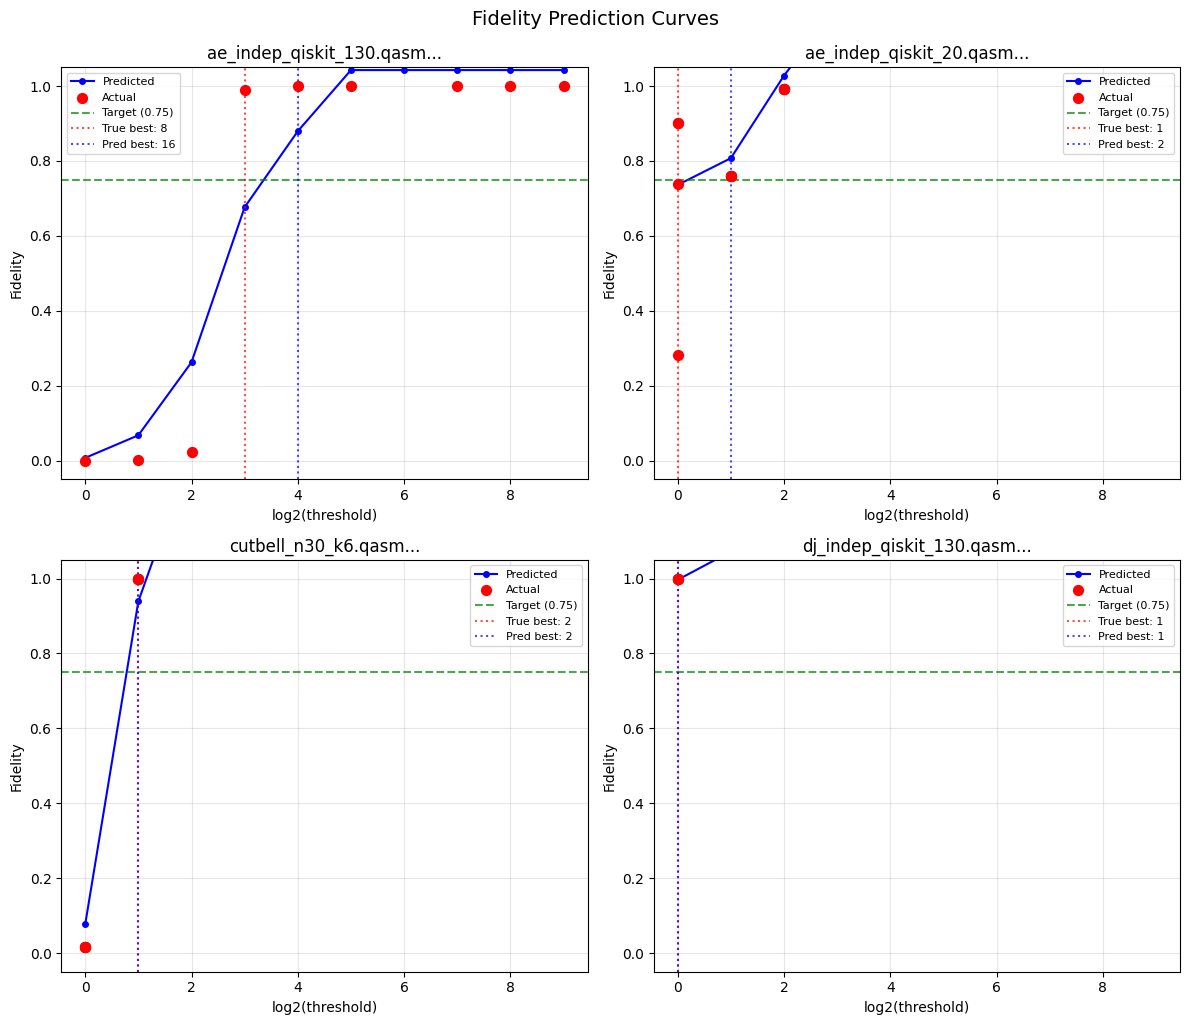

In [97]:
# Visualize: Predicted fidelity curves for sample circuits
import matplotlib.pyplot as plt

# Train a final fidelity model on all data
final_fidelity_model = HistGradientBoostingRegressor(**hgb_fidelity_params)
final_fidelity_model.fit(X_fidelity.values.astype(np.float32), y_fidelity)

# Pick a few sample circuits to visualize
sample_files = df_fidelity['file'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, file in zip(axes, sample_files):
    # Get circuit features
    mask = df_fidelity['file'] == file
    circuit_df = df_fidelity[mask]
    circuit_features = X_fidelity[mask].iloc[0].values[:-1]
    
    # True fidelity data
    true_thresholds = circuit_df['threshold'].values
    true_fidelities = circuit_df['fidelity'].values
    true_min_thresh = df_features[df_features['file'] == file]['min_threshold'].values[0]
    
    # Predicted fidelity curve
    pred_thresh, pred_fidelities = predict_best_threshold(final_fidelity_model, circuit_features)
    
    # Plot
    ax.plot(ALL_LOG2_THRESHOLDS, pred_fidelities, 'b-o', label='Predicted', markersize=4)
    ax.scatter(np.log2(true_thresholds), true_fidelities, c='red', s=50, zorder=5, label='Actual')
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='Target (0.75)')
    ax.axvline(x=np.log2(true_min_thresh), color='red', linestyle=':', alpha=0.7, label=f'True best: {true_min_thresh}')
    ax.axvline(x=np.log2(pred_thresh), color='blue', linestyle=':', alpha=0.7, label=f'Pred best: {pred_thresh}')
    
    ax.set_xlabel('log2(threshold)')
    ax.set_ylabel('Fidelity')
    ax.set_title(f'{file[:30]}...')
    ax.legend(fontsize=8)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Fidelity Prediction Curves', y=1.02, fontsize=14)
plt.show()

---

## Ensemble Stacking

Combine multiple diverse models with a meta-learner to get better predictions than any single model.

In [8]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings

# Define diverse base estimators
base_estimators = [
    ('catboost', CatBoostClassifier(
        iterations=300, depth=6, learning_rate=0.05,
        random_seed=42, verbose=False
    )),
    ('xgboost', XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        random_state=42, verbosity=0, use_label_encoder=False
    )),
    ('histgb', HistGradientBoostingClassifier(
        max_iter=300, max_depth=6, learning_rate=0.05, random_state=42
    )),
    ('rf', RandomForestClassifier(
        n_estimators=300, max_depth=10, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    )),
    ('extra_trees', ExtraTreesClassifier(
        n_estimators=300, max_depth=10, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    )),
]

# Meta-learner: Logistic Regression (simple, less prone to overfitting)
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=3,  # 3-fold CV for generating meta-features
    stack_method='predict_proba',
    n_jobs=-1,
    passthrough=False  # Don't include original features in meta-learner
)

print("Stacking Ensemble:")
print(f"  Base models: {[name for name, _ in base_estimators]}")
print(f"  Meta-learner: LogisticRegression")
print(f"  CV for stacking: 3-fold")

Stacking Ensemble:
  Base models: ['catboost', 'xgboost', 'histgb', 'rf', 'extra_trees']
  Meta-learner: LogisticRegression
  CV for stacking: 3-fold


In [9]:
# Prepare data and evaluate stacking ensemble with K-Fold CV
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load and prepare data
df = pd.read_csv("training_data_75.csv")
y_full = df["min_threshold"].astype(int).values
groups_full = df["file"].astype(str).values

drop_cols = ["min_threshold", "file", "family", "forward_runtime", 
             "max_fidelity_achieved", "forward_shots", "forward_peak_rss_mb", "n_thresholds_tested"]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols).copy()
X = pd.get_dummies(X, columns=[c for c in X.columns if X[c].dtype == "object"])
X_full = X.values.astype(np.float32)

print(f"Data: {X_full.shape[0]} samples, {X_full.shape[1]} features, {len(np.unique(y_full))} classes")
print()

def evaluate_stacking_kfold(clf, X, y, groups, n_splits=None, name="Stacking"):
    """Evaluate stacking classifier with grouped k-fold CV."""
    
    if n_splits is None:
        min_class = min(np.bincount(y)[np.bincount(y) > 0])
        n_splits = min(5, min_class)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        fold_accs = []
        all_true, all_pred = [], []
        
        for fold_idx, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            from sklearn.base import clone
            clf_fold = clone(clf)
            clf_fold.fit(X_train, y_train)
            
            y_pred = clf_fold.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            fold_accs.append(acc)
            
            all_true.extend(y_test)
            all_pred.extend(y_pred)
            
            print(f"  Fold {fold_idx+1}: Acc={acc:.4f}")
        
        mean_acc = np.mean(fold_accs)
        std_acc = np.std(fold_accs)
        
        print(f"\n{name} - {n_splits}-Fold CV Results:")
        print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        
        classes = sorted(np.unique(y))
        cm = confusion_matrix(all_true, all_pred, labels=classes)
        print(f"\nConfusion Matrix:")
        print(f"Classes: {classes}")
        print(cm)
        
        return {"mean_acc": mean_acc, "std_acc": std_acc, "fold_accs": fold_accs}

print("Evaluating Stacking Ensemble (this may take a minute)...")
print()
results_stacking = evaluate_stacking_kfold(
    stacking_clf, X_full, y_full, groups_full, 
    name="Stacking Ensemble"
)

ValueError: could not convert string to float: 'CPU'

In [ ]:
# Also try Voting Ensemble (often more robust than stacking with small data)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=base_estimators,
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

print("Evaluating Voting Ensemble...")
print()
results_voting = evaluate_stacking_kfold(
    voting_clf, X_full, y_full, groups_full,
    name="Voting Ensemble (soft)"
)

In [ ]:
# Final comparison: Ensemble models
print("="*70)
print("ENSEMBLE COMPARISON")
print("="*70)

all_results = [
    ("Stacking Ensemble", results_stacking['mean_acc'], results_stacking['std_acc']),
    ("Voting Ensemble", results_voting['mean_acc'], results_voting['std_acc']),
]

# Sort by accuracy
all_results.sort(key=lambda x: -x[1])

print("\nRanked by accuracy:")
for i, (name, acc, std) in enumerate(all_results, 1):
    marker = "👑" if i == 1 else "  "
    print(f"{marker} {i}. {name:25s}: {acc:.4f} ± {std:.4f}")

best_name, best_acc, _ = all_results[0]
baseline = 0.394  # Majority class baseline

print(f"\n{'='*70}")
print(f"Best ensemble: {best_name} with {best_acc:.1%} accuracy")
print(f"Majority baseline: 39.4%")
print(f"Improvement: +{(best_acc - baseline)*100:.1f}%")
print(f"{'='*70}")

**Modelos**

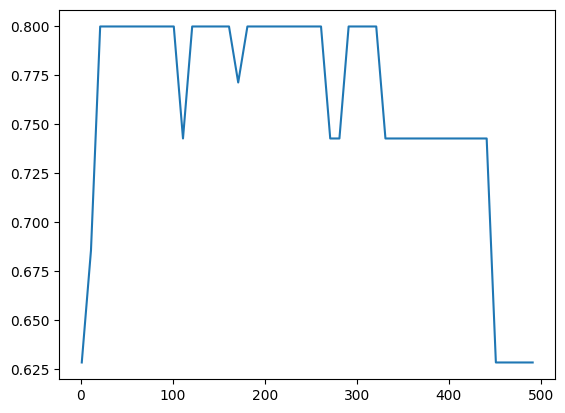

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

estim = []
acc = []

for estimator in range(1, 500, 10):

    clf1 = ExtraTreesClassifier(
        n_estimators=estimator,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    )

    clf1.fit(x_train, y_train)

    pred = clf1.predict(x_test)
    acc.append(cls_metrics(y_test, pred, name="ExtraTreesClassifier"))

    estim.append(estimator)
    
plt.plot(estim, acc)


    

In [33]:
pred = clf1.predict(x_test)

cls_metrics(y_test, pred, name="ExtraTreesClassifier")


0.6285714285714286

In [45]:
from sklearn.ensemble import RandomForestClassifier

max_acc = 0

for estimator in range(100, 1000, 100):
    for depth in [None, 10, 20, 30]:
        for samples in range(1, 11):
            clf_rf = RandomForestClassifier(
                n_estimators=estimator,
                max_depth=depth,
                min_samples_leaf=samples,
                random_state=42,
                n_jobs=-1,
                class_weight="balanced"
            )
            
            clf_rf.fit(x_train, y_train)

            pred = clf_rf.predict(x_test)

            acc = cls_metrics(y_test, pred, name="RandomForestClassifier")

            if acc >= max_acc:
                max_acc = acc

                print(f'acc {acc}')
                print(f'estimator {estimator}')
                print(f'depth {depth}')
                print(f'samples {samples}')
                print()

            
            




acc 0.6285714285714286
estimator 100
depth None
samples 1

acc 0.6857142857142857
estimator 100
depth None
samples 2

acc 0.6857142857142857
estimator 100
depth 10
samples 2

acc 0.6857142857142857
estimator 100
depth 20
samples 2

acc 0.6857142857142857
estimator 100
depth 30
samples 2

acc 0.6857142857142857
estimator 200
depth None
samples 1

acc 0.6857142857142857
estimator 200
depth None
samples 2

acc 0.6857142857142857
estimator 200
depth 10
samples 1

acc 0.6857142857142857
estimator 200
depth 10
samples 2

acc 0.6857142857142857
estimator 200
depth 20
samples 1

acc 0.6857142857142857
estimator 200
depth 20
samples 2

acc 0.6857142857142857
estimator 200
depth 30
samples 1

acc 0.6857142857142857
estimator 200
depth 30
samples 2

acc 0.6857142857142857
estimator 300
depth None
samples 1

acc 0.6857142857142857
estimator 300
depth None
samples 2

acc 0.6857142857142857
estimator 300
depth 10
samples 1

acc 0.6857142857142857
estimator 300
depth 10
samples 2

acc 0.6857142857142

In [43]:
pred = clf_rf.predict(x_test)
cls_metrics(y_test, pred, name="RF")

0.6857142857142857

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=8,
    max_iter=2500,
    random_state=42
)

clf_hgb.fit(x_train, y_train)


,"loss loss: {'log_loss'}, default='log_loss'The loss function to use in the boosting process.For binary classification problems, 'log_loss' is also known as logistic loss,binomial deviance or binary crossentropy. Internally, the model fits one treeper boosting iteration and uses the logistic sigmoid function (expit) asinverse link function to compute the predicted positive class probability.For multiclass classification problems, 'log_loss' is also known as multinomialdeviance or categorical crossentropy. Internally, the model fits one tree perboosting iteration and per class and uses the softmax function as inverse linkfunction to compute the predicted probabilities of the classes.",'log_loss'
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees for binary classification. For multiclassclassification, `n_classes` trees per iteration are built.",2500
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",8
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide `... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.4 Added `""from_dtype""` option... versionchanged:: 1.6 The default value changed from `None` to `""from_dtype""`.",'from_dty

In [23]:
pred = clf_hgb.predict(x_test)
cls_metrics(y_test, pred, name="RF")

RF
  Accuracy: 0.8
  Under-rate (pred < true): 0.0857
  Over-rate  (pred > true): 0.1143


0.8

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

clf_gb.fit(x_train, y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",300
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",10
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``

In [108]:
pred = clf_gb.predict(x_test)
cls_metrics(y_test, pred, name="GB")

GB
  Accuracy: 0.4571
  Under-rate (pred < true): 0.3143
  Over-rate  (pred > true): 0.2286


In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=4, random_state=42),
    n_estimators=1500,
    learning_rate=0.05,
    random_state=42
)

clf_ada.fit(x_train_c1, y_train_c1)


,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeC...ndom_state=42)
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",1500
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",0.05
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None


In [16]:
pred = clf_ada.predict(x_test_c1)
threshold_metrics(y_test_c1, pred, name="ADA")

ADA THRESHOLD METRICS
  Accuracy (exact rung): 0.6061
  Under-rate (pred < true): 0.2727
  Over-rate  (pred > true): 0.1212
  Mean rung distance (log2 steps): 0.6061


{'acc': 0.6060606060606061,
 'under': 0.2727272727272727,
 'over': 0.12121212121212122,
 'mean_steps': 0.6060606060606061}

In [19]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(
    solver="lbfgs",
    C=2.0,
    max_iter=5000,
    n_jobs=-1
)

clf_lr.fit(x_train_c1, y_train_c1)


c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",2.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [35]:
pred = clf_lr.predict(x_test_c1)
threshold_metrics(y_test_c1, pred, name="ADA")

ADA THRESHOLD METRICS
  Accuracy (exact rung): 0.4545
  Under-rate (pred < true): 0.1818
  Over-rate  (pred > true): 0.3636
  Mean rung distance (log2 steps): 2.1212


{'acc': 0.45454545454545453,
 'under': 0.18181818181818182,
 'over': 0.36363636363636365,
 'mean_steps': 2.121212121212121}

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

clf_linsvc = Pipeline([
    ("sc", StandardScaler()),
    ("svm", LinearSVC(C=2.0, class_weight="balanced", random_state=42))
])

clf_linsvc.fit(x_train_c1, y_train_c1)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('sc', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [34]:
pred = clf_linsvc.predict(x_test_c1)
threshold_metrics(y_test_c1, pred, name="LinearSVC")

# Optional:
# eval_groupkfold_classifier(clf_linsvc, X_c1_enc, y_c1, groups_c1, n_splits=5, name="LinearSVC")


LinearSVC THRESHOLD METRICS
  Accuracy (exact rung): 0.8182
  Under-rate (pred < true): 0.0606
  Over-rate  (pred > true): 0.1212
  Mean rung distance (log2 steps): 0.6667


{'acc': 0.8181818181818182,
 'under': 0.06060606060606061,
 'over': 0.12121212121212122,
 'mean_steps': 0.6666666666666666}

In [36]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance",
    metric="minkowski",
    p=2
)

clf_knn.fit(x_train_c1, y_train_c1)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [37]:
pred = clf_knn.predict(x_test_c1)
threshold_metrics(y_test_c1, pred, name="KNeighborsClassifier")

# Optional:
# eval_groupkfold_classifier(clf_knn, X_c1_enc, y_c1, groups_c1, n_splits=5, name="KNeighborsClassifier")


KNeighborsClassifier THRESHOLD METRICS
  Accuracy (exact rung): 0.3636
  Under-rate (pred < true): 0.3939
  Over-rate  (pred > true): 0.2424
  Mean rung distance (log2 steps): 1.6970


{'acc': 0.36363636363636365,
 'under': 0.3939393939393939,
 'over': 0.24242424242424243,
 'mean_steps': 1.696969696969697}

In [51]:
from catboost import CatBoostClassifier, CatBoostRegressor

mac_acc = 0

for i in range(100, 1000, 100):
    for j in range(1, 11):
        for k in range(1, 10):
            clf_cb = CatBoostClassifier(
                iterations=i,
                depth=j,
                learning_rate=k/100,
                loss_function="MultiClass",
                eval_metric="Accuracy",
                random_seed=42,
                verbose=False
            )
            
            clf_cb.fit(x_train, y_train)
            
            pred = clf_cb.predict(x_test)
            
            acc = cls_metrics(y_test, pred, name="CatBoostClassifier")

            if acc >= max_acc:
                max_acc = acc
                print(acc, i, j, k/100)

0.6857142857142857 100 1 0.02
0.8 100 2 0.01
0.8 100 2 0.02
0.8 100 2 0.03
0.8 100 2 0.04
0.8 100 2 0.05
0.8 100 2 0.07
0.8 100 2 0.08
0.8 100 2 0.09
0.8 100 3 0.01
0.8 100 4 0.01
0.8 100 4 0.02
0.8 100 4 0.03
0.8 100 4 0.04
0.8 100 4 0.05
0.8 100 4 0.06
0.8 100 4 0.07
0.8 100 4 0.08
0.8 100 5 0.01
0.8 100 6 0.01
0.8 100 6 0.02
0.8 100 6 0.03
0.8 100 7 0.02
0.8 100 7 0.03
0.8 100 7 0.04
0.8 100 7 0.05
0.8 100 7 0.06
0.8 100 7 0.07
0.8 100 7 0.08
0.8 100 8 0.01
0.8 100 8 0.04
0.8 100 9 0.05
0.8 100 10 0.02
0.8 100 10 0.03
0.8 200 2 0.01
0.8 200 2 0.02
0.8 200 2 0.03
0.8 200 2 0.04
0.8 200 2 0.07
0.8 200 3 0.01
0.8 200 4 0.01
0.8 200 4 0.07
0.8 200 5 0.01
0.8 200 6 0.01
0.8 200 6 0.04
0.8 200 7 0.01
0.8 200 7 0.02
0.8 200 7 0.04
0.8 200 7 0.05
0.8 200 7 0.06
0.8 200 8 0.01
0.8 200 9 0.01
0.8 200 10 0.02
0.8 300 2 0.01
0.8 300 2 0.02
0.8 300 2 0.03
0.8 300 2 0.07
0.8 300 3 0.01
0.8 300 6 0.04
0.8 300 7 0.01
0.8 300 7 0.02
0.8 300 7 0.05
0.8 300 9 0.01
0.8 300 10 0.02
0.8 400 2 0.02
0.8 40